In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, Flatten, Dense, Reshape


Discriminator network:

In [ ]:
Discriminator = Sequential()

#Discriminator.add(BatchNormalization(input_shape=(256,256,3)))
Discriminator.add(Conv2D(16, (4,4), strides = 2, input_shape = (256,256,3)))
Discriminator.add(LeakyReLU())
Discriminator.add(Conv2D(16, (4,4), strides = 2))
Discriminator.add(LeakyReLU())
Discriminator.add(Dropout(.5))
Discriminator.add(Flatten())
Discriminator.add(Dense(1, activation='sigmoid'))

disc_optim = Adam(learning_rate = .0001)
Discriminator.compile(loss='binary_crossentropy', optimizer=disc_optim, metrics=['accuracy'])
print(Discriminator.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 127, 127, 16)      784       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 127, 127, 16)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 62, 62, 16)        4112      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 62, 62, 16)        0         
                                                                 
 dropout_6 (Dropout)         (None, 62, 62, 16)        0         
                                                                 
 flatten_7 (Flatten)         (None, 61504)             0         
                                                                 
 dense_21 (Dense)            (None, 1)               

Blend-based generator with dense layers (it will tweak a blend input):

In [110]:
Generator2 = Sequential()

Generator2.add(Dense(128, activation = 'relu', input_shape = (256,256,3)))
#Generator2.add(Dense(64, activation = 'relu'))
Generator2.add(Dense(3, activation = 'tanh'))
               
Generator2.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 256, 256, 128)     512       
                                                                 
 dense_23 (Dense)            (None, 256, 256, 3)       387       
                                                                 
Total params: 899
Trainable params: 899
Non-trainable params: 0
_________________________________________________________________


GAN composite network (locks Discriminator when trained; Discriminator trains separately):

In [111]:
def GAN_Model(generator, discriminator):
    discriminator.trainable = False
    GAN = Sequential()
    GAN.add(generator)
    GAN.add(discriminator)
    optim = Adam(learning_rate = .002)
    loss = BinaryCrossentropy(from_logits = False)
    GAN.compile(loss = loss, optimizer = optim)
    return GAN

gan_model = GAN_Model(Generator2, Discriminator)
gan_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_21 (Sequential)  (None, 256, 256, 3)       899       
                                                                 
 sequential_20 (Sequential)  (None, 1)                 66401     
                                                                 
Total params: 67,300
Trainable params: 899
Non-trainable params: 66,401
_________________________________________________________________


Training Phase:

*blends* are defined by doubled point-wise product.  Note this will trigger some clipping for average pixel values above about .7 in $[0,1]$ range, but it is to compensate for average halving for those below.  Technically the [image overlay](https://en.wikipedia.org/wiki/Blend_modes#Overlay) method would be ideal.

In [130]:
epochs = 100
N = 100
batch_size = 10
batch_update_freq = 5

num_of_batches = N/batch_size
accuracies = []
g_losses = []

for epoch in range(epochs):
    for batch in range(round(num_of_batches)):
        templates = x_train[np.random.randint(240, 5870, size = batch_size)]
        monetoverlay = x_train[np.random.randint(0, 240, size = batch_size)]
        blends = 2*(templates*monetoverlay)
        fakes = Generator2.predict(blends)
        #fakes = (fakes + 1)/2.0
        reals = x_train[np.random.randint(0, 240, size = batch_size)]
        x = np.vstack((reals,fakes))
        labels = np.zeros(2*batch_size)
        labels[0:batch_size] = 1.0
        d_loss = Discriminator.train_on_batch(x, labels)
        gen_labels = np.ones(batch_size)
        g_loss = gan_model.train_on_batch(blends, gen_labels)
        accuracies.append(d_loss[1])
        g_losses.append(g_loss)
        if batch%batch_update_freq == 0:
            print(f'Epoch:  {epoch},  Batch:  {batch},  Discriminator Loss:  {d_loss},   Generator Loss:  {g_loss}')
            
print(f'Epoch:  {epoch},  Batch:  {batch},  Discriminator Loss:  {d_loss},   Generator Loss:  {g_loss}')           

1/1 [==============================] - 0s 110ms/step
Epoch:  0,  Batch:  0,  Discriminator Loss:  [0.4030252993106842, 0.8999999761581421],   Generator Loss:  1.4178110361099243
1/1 [==============================] - 0s 105ms/step
Epoch:  0,  Batch:  5,  Discriminator Loss:  [0.37930670380592346, 0.800000011920929],   Generator Loss:  1.66828191280365
1/1 [==============================] - 0s 110ms/step
Epoch:  1,  Batch:  0,  Discriminator Loss:  [0.28774821758270264, 1.0],   Generator Loss:  1.455034613609314
1/1 [==============================] - 0s 105ms/step
Epoch:  1,  Batch:  5,  Discriminator Loss:  [0.4011507034301758, 0.8999999761581421],   Generator Loss:  1.081111192703247
1/1 [==============================] - 0s 107ms/step
Epoch:  2,  Batch:  0,  Discriminator Loss:  [0.6590081453323364, 0.699999988079071],   Generator Loss:  0.9489348530769348
1/1 [==============================] - 0s 106ms/step
Epoch:  2,  Batch:  5,  Discriminator Loss:  [0.7649317979812622, 0.60000002

Plots for Discriminator accuracies and Generator Losses over time:

In [131]:
def accuracies_plot():
    x = np.arange(0, 5*epochs, step = 1/num_of_batches)
    y = accuracies
    plt.title('Discriminator Accuracies over Time')
    plt.xlabel('Epochs')
    Epochs = [f'Epoch {i}' for i in range(1, epochs+1)]
    plt.ylabel('Accuracy')
    plt.plot(x, y)
    plt.show()

def g_losses_plot():
    x = np.arange(0, 5*epochs, step = 1/num_of_batches)
    y = g_losses
    plt.title('Generator Losses over Time')
    plt.xlabel('Epochs')
    Epochs = [f'Epoch {i}' for i in range(1, epochs+1)]
    plt.ylabel('Generator Loss')
    plt.plot(x, y)
    plt.show()

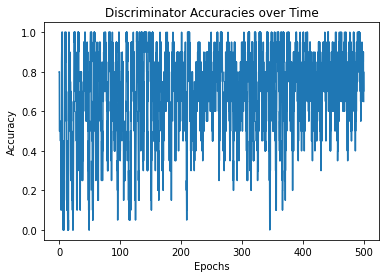

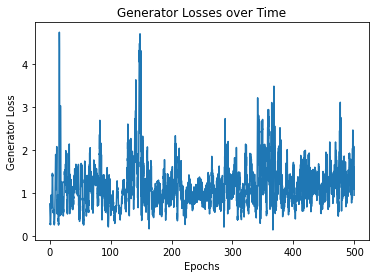

In [132]:
accuracies_plot()
g_losses_plot()

Sample generated images after training: **n** images with **k** shown per row:

1/1 [==============================] - 0s 298ms/step


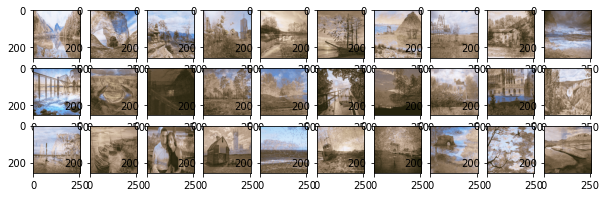

In [136]:
# n total fakes, k per row;  ensure k divides n
def showimages(n,k):
    templates = x_train[np.random.randint(240, 5870, size = n)]
    monetoverlay = x_train[np.random.randint(0, 240, size = n)]
    blends = 2*(templates*monetoverlay)
    generation = Generator2.predict(blends)
    #generation = (generation + 1)/2.0
    #generation = np.round_(generation*255).astype(np.uint8)
    f, a = plt.subplots(int(n/k), k, figsize=(k, int(n/k)))
    for i in range(int(n/k)): # total rows
        for j in range(k): # total columns
            a[i][j].imshow(np.reshape(generation[i*k + j], (256,256,3)))

showimages(30,10)

Check discriminator on test set:

In [136]:
Discriminator.evaluate(x_test[0:120], y_test[0:120], batch_size = 1)

120/120 [==============================] - 1s 5ms/step - loss: 0.9628 - accuracy: 0.4167


[0.9627525806427002, 0.4166666567325592]

Writing to zip files if needed:

In [33]:
import zipfile
from zipfile import ZipFile
import cv2

In [73]:
def generation(N):
    templates = x_train[np.random.randint(240, 5870, size = N)]
    monetoverlay = x_train[np.random.randint(0, 240, size = N)]
    blends = 2*(templates*monetoverlay)
    generated = Generator2(blends)
    zf = ZipFile('zipper.zip', 'w', zipfile.ZIP_DEFLATED)
    for n in range(N):
        image = np.round_(generation2[N]*255).astype('uint8')
        buffer = cv2.imencode('.jpg', image)[1].tobytes()
        zf.writestr('image'+str(N)+'.jpg', buffer)
    zf.close()
    
num_of_generated = 10

generation(num_of_generated)